# DLL 52 Basics of NLP in Radiology - RSNA 2021

This session will feature a brief lecture introducing the basics of natural language processing (NLP) and highlight potential uses for it in radiology. This accompanying notebook will provide hands-on opportunity to explore some of the basic tools of NLP available in Python. 

**Learning Objectives:**
1.   Understand common terminology and preprocessing techniques in NLP
2.   Identify several classic and modern approaches used to capture semantic meaning in text
3. Learn how to implement a basic NLP pipeline from preprocessing to performance evaluation

**Session Authors**

Timothy L. Chen MD - University of California San Francisco, San Francisco, USA

Jae Ho Sohn MD, MS - University of California San Francisco, San Francisco, USA





# Install Packages

We will use a number of prepackaged python NLP tools for this demonstration. Google colab instances come preloaded with a number of packages but not everything. We will install the missing packages here.

Natural Language Toolkit ([NLTK](https://www.nltk.org/))

[spacy](https://spacy.io/) and [scispacy](https://allenai.github.io/scispacy/)

[gensim](https://radimrehurek.com/gensim/)

[sklearn](https://scikit-learn.org/stable/)






In [2]:
#@title Installing missing required packages
!pip install xmltodict >/dev/null
!pip install spacy > /dev/null 
!pip install scispacy > /dev/null
!pip install negspacy > /dev/null
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_md-0.4.0.tar.gz> /dev/null

#! pip freeze

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-core-sci-md 0.4.0 requires spacy<3.1.0,>=3.0.1, but you have spacy 3.4.3 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scispacy 0.5.1 requires spacy<3.5.0,>=3.4.0, but you have spacy 3.0.8 which is incompatible.
en-core-web-sm 3.4.1 requires spacy<3.5.0,>=3.4.0, but you have spacy 3.0.8 which is incompatible.


# Acquiring Data

This demo will utilize data from the [Indiana University CXR dataset](https://openi.nlm.nih.gov/faq). 

More information regarding the creation of this dataset is detailed in [1] *Demner-Fushman et. al. "Preparing a collection of radiology examinations for distirbution and retrieval". J. Am. Med. Inform. Assoc. 2016. doi: [10.1093/jamia/ocv080](https://academic.oup.com/jamia/article/23/2/304/2572395)*

In [3]:
# Download the data
# tar options - x -extract, v - show progress of archive file, z - filter archive through gzip
!curl https://openi.nlm.nih.gov/imgs/collections/NLMCXR_reports.tgz > NLMCXR_reports.tgz
!tar xvf /content/NLMCXR_reports.tgz >/dev/null


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1086k  100 1086k    0     0  10.7M      0 --:--:-- --:--:-- --:--:-- 10.7M


In [4]:
# taking a closer look at our file hierarchy
!dir

ecgen-radiology  NLMCXR_reports.tgz  sample_data


In [5]:
#Converting .csv files to .xml File
#Credit, Heavily Inspired: https://stackoverflow.com/questions/41059264/simple-csv-to-xml-conversion-python
import csv  
import pandas as pd

csv_file = ''
output_xml = ''
def csv_to_xml(csv_file, output_xml):
  # Parameters: 
  #   csv_file: The location of the csv file 
  #   output_xml: The location of the output xml file
  # Output: None, writes the content of the csv file to output_xml
  f = open(csv_file)
  csv_f = csv.reader(f)   
  data = []

  for row in csv_f: 
    data.append(row)
  f.close()

  df = pd.read_csv(csv_file)
  header = list(df.columns)

  def convert_row(row):
      str_row = """<%s>%s</%s> \n"""*(len(header)-1)
      str_row = """<%s>%s""" +"\n"+ str_row + """</%s>"""
      var_values = [list_of_elments[k] for k in range(1,len(header)) for list_of_elments in [header,row,header]]
      var_values = [header[0],row[0]]+var_values+[header[0]]
      var_values =tuple(var_values)
      return str_row % var_values

  text = """<collection shelf="New Arrivals">"""+"\n"+'\n'.join([convert_row(row) for row in data[1:]])+"\n" +"</collection >"
  print(text)
  with open('output.xml', 'w') as myfile: 
    myfile.write(text)

  df= pd.read_csv(csv_file)
  with open(output_xml, 'w') as myfile: 
    myfile.write(df.to_xml())

With permission from [2] Wiggins et. al., we borrow code to parse the xml. More information about this code can be found here: [Natural Language Processing of Radiology Text Reports: Interactive Text Classification](https://pubs.rsna.org/doi/full/10.1148/ryai.2021210035)

The XML file format stores data under various headers which we store as key-value pairs in a python dictionary object.

Here we first examine the data stucture of one such xml using an explicit file path. We want to extract the relevant text information from each file. We are interested in the text from the "FINDINGS" AND "IMPRESSION" keys. In addition, the reports are labeled as normal under the MeSH key - we will use this for labeling the reports as normal (if normal is present under MeSH) or abnormal.

If we closely examine the data, there are some oddities. Some entries are multiple xrays together. For example, 875.xml contains text for both CXR and a knee X-ray. Some CXR have no text under FINDINGS and IMPRESSION. For some chest x-ray, there is no label given ("No Indexing"). These "No Indexing" labels will be considered as normal for this exercise. 

In [6]:
import xmltodict

# function from Wiggins et. al.
def xml_parse(f):
  with open(f) as xml:
    report_dict = xmltodict.parse(xml.read())
    xml.close()
  return report_dict

Let's take a look at a random xml file and see the contents after parsing

In [7]:
reportdict_1 = xml_parse("./ecgen-radiology/1404.xml")
reportdict_1

{'eCitation': {'meta': {'@type': 'rr'},
  'uId': {'@id': 'CXR1404'},
  'pmcId': {'@id': '1404'},
  'docSource': 'CXR',
  'IUXRId': {'@id': '1404'},
  'licenseType': 'open-access',
  'licenseURL': 'http://creativecommons.org/licenses/by-nc-nd/4.0/',
  'ccLicense': 'byncnd',
  'articleURL': None,
  'articleDate': '2013-08-01',
  'articleType': 'XR',
  'publisher': 'Indiana University',
  'title': 'Indiana University Chest X-ray Collection',
  'note': 'The data are drawn from multiple hospital systems.',
  'specialty': 'pulmonary diseases',
  'subset': 'CXR',
  'MedlineCitation': {'@Owner': 'Indiana University',
   '@Status': 'supplied by publisher',
   'Article': {'@PubModel': 'Electronic',
    'Journal': {'JournalIssue': {'PubDate': {'Year': '2013',
       'Month': '08',
       'Day': '01'}}},
    'ArticleTitle': 'Indiana University Chest X-ray Collection',
    'Abstract': {'AbstractText': [{'@Label': 'COMPARISON', '#text': 'XXXX'},
      {'@Label': 'INDICATION',
       '#text': 'XXXX y


The entirety of the of the xml data files were uncompressed into the "ecgen-radiology" folder, so we will need to go through each file and extract the relevant information. The [glob](https://docs.python.org/3/library/glob.html) function in the glob module makes this easy by matching all files whose pathname matches a given pattern using [fnmatch](https://docs.python.org/3/library/fnmatch.html#module-fnmatch)

Additionally, we will extract relevant information from each xml file and store it into a pandas dataframe (which is basically a table).

In [8]:
# functions from Wiggins et. al. , slightly modified to remove dependence on fastai L class

def get_label(report):
    label = report['eCitation']['MeSH']['major']
    return 'normal' if label == 'normal' or label == "No Indexing" else 'abnormal'

def get_text(report):
    text_dict = {}
    text_dict['id'] = report['eCitation']['IUXRId']['@id']
    text = report['eCitation']['MedlineCitation']['Article']['Abstract']['AbstractText']
    findings = text[2]['#text'] if '#text' in text[2] else ''
    text_dict['findings'] = findings
    impression = text[3]['#text'] if '#text' in text[3] else ''
    text_dict['impression'] = impression
    text_dict['full-text'] = ' '.join([findings, impression])
    return text_dict

def process_report(report):
    label = get_label(report)
    report_dict = get_text(report)
    report_dict['label'] = label
    return report_dict


In [9]:
import glob
import pandas as pd

files = glob.glob("./ecgen-radiology/*")
reports = list()
reports_unlabeled = list()

for file in files:
  report_extract = xml_parse(file)
  if report_extract['eCitation']['MeSH']['major'] == "No Indexing":
    reports_unlabeled.append(file)
    
  reports.append(process_report(report_extract))
  
reports_df = pd.DataFrame(reports)


Let's examine some of the data in our table

The .head() function will return the first n rows (default 5) of the table. The .sample() method will randomly choose n rows of the table to display (default is 1)

In [10]:
print("# of reports:",reports_df.shape[0])
pd.options.display.max_colwidth = 0
reports_df.head()

# of reports: 3955


,id,findings,impression,full-text,label
0,3020,Heart size and mediastinal contours are normal in appearance. No consolidative airspace opacities. No radiographic evidence of pleural effusion or pneumothorax. Visualized osseous structures appear intact.,No acute cardiopulmonary abnormality.,Heart size and mediastinal contours are normal in appearance. No consolidative airspace opacities. No radiographic evidence of pleural effusion or pneumothorax. Visualized osseous structures appear intact. No acute cardiopulmonary abnormality.,normal
1,622,Both lungs are clear and expanded. Heart and mediastinum normal.,No active disease.,Both lungs are clear and expanded. Heart and mediastinum normal. No active disease.,normal
2,3731,Lungs are clear. Heart and mediastinum appear normal. No pleural effusion or pneumothorax.,Negative chest,Lungs are clear. Heart and mediastinum appear normal. No pleural effusion or pneumothorax. Negative chest,normal
3,825,,"Patchy bilateral airspace disease with pulmonary XXXX, XXXX a combination of atelectasis and consolidation. Borderline cardiac enlargement. Tracheostomy tube tip 6.4 cm above the carina.","Patchy bilateral airspace disease with pulmonary XXXX, XXXX a combination of atelectasis and consolidation. Borderline cardiac enlargement. Tracheostomy tube tip 6.4 cm above the carina.",abnormal
4,3321,XXXX XXXX and lateral chest examination was obtained. The heart silhouette is normal in size and contour. Aortic XXXX appear unremarkable. Lungs demonstrate no acute findings. There is no effusion or pneumothorax.,1. No acute pulmonary disease.,XXXX XXXX and lateral chest examination was obtained. The heart silhouette is normal in size and contour. Aortic XXXX appear unremarkable. Lungs demonstrate no acute findings. There is no effusion or pneumothorax. 1. No acute pulmonary disease.,normal


In [11]:
reports_df.sample(5)

,id,findings,impression,full-text,label
1598,1865,Heart size is normal. The lungs are clear. There are no focal air space consolidations. No pleural effusions or pneumothoraces. Calcified right upper lobe pulmonary granuloma and calcified right hilar lymph XXXX. The hilar and mediastinal contours are normal. Normal pulmonary vascularity.,No acute abnormality. .,Heart size is normal. The lungs are clear. There are no focal air space consolidations. No pleural effusions or pneumothoraces. Calcified right upper lobe pulmonary granuloma and calcified right hilar lymph XXXX. The hilar and mediastinal contours are normal. Normal pulmonary vascularity. No acute abnormality. .,abnormal
2220,8,"The heart, pulmonary XXXX and mediastinum are within normal limits. There is no pleural effusion or pneumothorax. There is no focal air space opacity to suggest a pneumonia. There is an interim XXXX cervical spinal fusion partly evaluated.",No acute cardiopulmonary disease.,"The heart, pulmonary XXXX and mediastinum are within normal limits. There is no pleural effusion or pneumothorax. There is no focal air space opacity to suggest a pneumonia. There is an interim XXXX cervical spinal fusion partly evaluated. No acute cardiopulmonary disease.",normal
2362,3112,The heart is normal in size. The mediastinum is unremarkable. The lungs are clear.,No acute disease.,The heart is normal in size. The mediastinum is unremarkable. The lungs are clear. No acute disease.,normal
3633,1906,,"Streaky bibasilar opacities most suggestive of atelectasis with hypoventilation. Heart size mildly enlarged for technique, stable mediastinal contours. No definite pleural effusion seen, no typical findings of pulmonary edema.","Streaky bibasilar opacities most suggestive of atelectasis with hypoventilation. Heart size mildly enlarged for technique, stable mediastinal contours. No definite pleural effusion seen, no typical findings of pulmonary edema.",abnormal
2377,3667,Density in the left upper lung on PA XXXX XXXX represents superimposed bony and vascular structures. There is calcification of the first rib costicartilage junction which XXXX contributes to this appearance. The lungs otherwise appear clear. The heart and pulmonary XXXX appear normal. In the pleural spaces are clear. The mediastinal contour is normal. There are degenerative changes of thoracic spine. There is an electronic cardiac device overlying the left chest wall with intact distal leads in the right heart.,"1. Irregular density in the left upper lung on PA XXXX, XXXX artifact related to superimposed vascular bony structures. Chest fluoroscopy or XXXX would confirm this 2. Otherwise, no acute cardiopulmonary disease.","Density in the left upper lung on PA XXXX XXXX represents superimposed bony and vascular structures. There is calcification of the first rib costicartilage junction which XXXX contributes to this appearance. The lungs otherwise appear clear. The heart and pulmonary XXXX appear normal. In the pleural spaces are clear. The mediastinal contour is normal. There are degenerative changes of thoracic spine. There is an electronic cardiac device overlying the left chest wall with intact distal leads in the right heart. 1. Irregular density in the left upper lung on PA XXXX, XXXX artifact related to superimposed vascular bony structures. Chest fluoroscopy or XXXX would confirm this 2. Otherwise, no acute cardiopulmonary disease.",abnormal


# Some characteristics of the data

We previously already noticed that not all reports had labels associated with them and kept track of a list of such reports in reports_unlabeled. Through further examination of the data we see that some reports (e.g. id 68) only have an impression section but no findings section. THere are also numerous XXXX in reports which likely represent placeholder text after PHI removal (names, dates, etc). Even for normal labeled reports, there is quite a large amount of variation in the text of the reports.

## Distribution of labels

For any data, it is important to examine the distribution of classes (labels) of the data. Imbalanced datasets can have large impacts in terms of how a model behaves after training. 

Abnormal: 2469
Normal: 1486



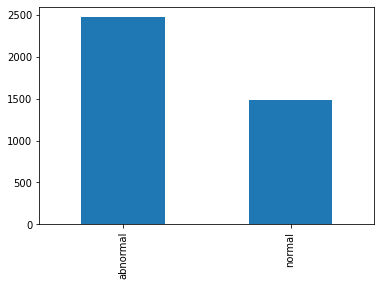

In [12]:
# code from Wiggins et. al.

label_counts = reports_df.label.value_counts()
print('Abnormal:', label_counts['abnormal'])
print('Normal:', label_counts['normal'])
print()
label_counts.plot.bar();

# Training and test set split

We will carve the data into two separate data sets - a training set to train the model and a test set to evaluate the model performance. It is necessary to use a separate dataset on which the model is not trained to evaluate the model because models can overfit onto training data and perform very well on that particular dataset but fail to generalize to examples it has not seen before.

Similarly, a third validation set is sometimes employed as part of the model development process for hyperparameter tuning which is  part of the training process.

For simplicity, we will use a single stratified train-test split, but a cross-validation approach with multiple train-test splits can offer better insight into how a model performs.

The stratification refers to how the sampling is done when the data is split into separate data sets. This is important when there is class imbalance in the dataset because you could conceivably end up with one dataset only having members of one class. 

The stratify option in the train_test_split function takes the labels of the dataset as input. When this option is enabled, the sampler will attempt to preserve class proportions of the input dataset (aka the input dataset labels) in the split datasets via stratified sampling. Note this does not solve the class imbalance problem on its own.

In [13]:
import numpy as np
from sklearn.model_selection import train_test_split

# fix seed for reproducibility
np.random.seed(2021)

train_df, test_df = train_test_split(reports_df, test_size=0.15, stratify=reports_df.label.values)

In [14]:
print("train_df shape: ", train_df.shape)
print("test_df shape: ", test_df.shape)

train_df shape:  (3361, 5)
test_df shape:  (594, 5)


If we examine the dataset labels of the test set, we can see that we have similar proportions of abnormal and normal labels compared to the original full dataset (approx 62% abnormal)

Test set size: 594
Abnormal: 371
Normal: 223



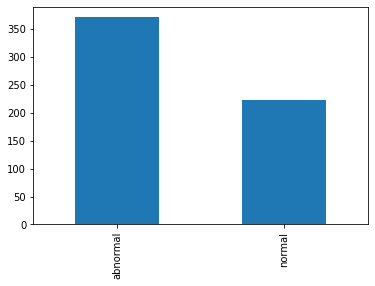

In [15]:
# code from Wiggins et. al.

print('Test set size:', test_df.shape[0])
test_counts = test_df.label.value_counts()
print('Abnormal:', test_counts['abnormal'])
print('Normal:', test_counts['normal'])
print()
test_counts.plot.bar();

# Preprocessing

Most models will not understand a stream of free text as is. Before we can use our data as input into a model, we need to convert it into a form that can be understood by an algorithm. Often this is done by creating a "vocabulary" of words such that every unique word has a unique index and thus we can input a word's index as input into a model (or use the index to look up some numerical representation of the word).

The following sections will examine pieces of a preprocessing pipeline in isolation using independent sections of code but then put these pieces together as one function at the end.

## Regular expressions (regex)
The data used in this tutorial was already nicely packaged into distinct Findings and Impression sections. Most of the time when working with radiology reports you'll have to divide the report into these separate entities yourself. One way to do this is with regular expressions which are rule based expressions that can match patterns of text. Regular expressions can be a powerful way to automatically segment reports or identify sections of text if pre-existing knowledge about their format is known.

[Cheat sheet](http://stanford.edu/~wpmarble/webscraping_tutorial/regex_cheatsheet.pdf) for regex syntax

We will not extensively cover regular expression nuances in this tutorial but just show a simple example of how they are used with respect to the Python re package. Regular expressions are a general framework thus you may also see packages outside of the re package which interface with regular expressions.

More about regular expressions can be found [here](https://www.regular-expressions.info/refflavors.html).


In [16]:
#@title
import re

regex_test_string = """
123-456-7890
(123)456-7890
(123)-456-7890
123 456 7890
123.456.7890
+1-123-456-7890
+1 (321) 456-7890
+91 123-456-7890
"""

regex_pattern = "\+?(\d{1,3})?[-. (]?[-. (]?(\d{3})[-. )]?[-. )]?\d{3}[-. ]?\d{4}"#@param {type:"string"}
m = re.finditer(regex_pattern,regex_test_string)

for match in m:
  print(match.group())
  print(f"Area code is {match.group(2)}\n")

123-456-7890
Area code is 123

(123)456-7890
Area code is 123

(123)-456-7890
Area code is 123

123 456 7890
Area code is 123

123.456.7890
Area code is 123

+1-123-456-7890
Area code is 123

+1 (321) 456-7890
Area code is 321

+91 123-456-7890
Area code is 123



Note by default regex does greedy matching
Greedy matching - match as much as text as possible to fulfill the pattern even if a smaller subsection of the text would have already fulfilled the pattern.

In the following example we look for a string that begins with "h", has at least one character of anything except line breaks, and then an "l".

If our test string is "hello" , then the substring "hel" matches our objective but so does "hell" if we go one character further. The default behavior is to return the longer version (hence greedy). If we wanted the non-greedy version, adding a "?" after a quantifier makes it non-greedy.

In [17]:
#@title
regex_pattern = "h.+l"
m = re.finditer(regex_pattern,"hello")
for match in m:
  print(match.group())

hell


In [18]:
#@title
regex_pattern = "h.+?l"
m = re.finditer(regex_pattern,"hello")
for match in m:
  print(match.group())

hel


## Word Tokenization

The first step in processing text is often tokenization. This is a process in which text is split into discrete sections which are known as tokens. A natural place to create these sections (for English) is dividing at spaces so that each word represents a token. However, tokens could also be defined at a phrase level (multiple words), sentence level, or character level. For simplicity here, we will tokenize at the single word level.

In [19]:
import nltk
nltk.download('punkt')
text = "Heart size upper limits of normal. Mediastinal contours are maintained. The patient is mildly rotated. There is a small to moderate sized right apical pneumothorax which measures approximately 2.0 cm. No focal airspace consolidation is seen. Left chest is clear. No definite displaced bony injury is seen. Results called XXXX. XXXX XXXX p.m. XXXX, XXXX. Small to moderate right apical pneumothorax."
text_tokens = nltk.tokenize.word_tokenize(text)
print(text_tokens)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


['Heart', 'size', 'upper', 'limits', 'of', 'normal', '.', 'Mediastinal', 'contours', 'are', 'maintained', '.', 'The', 'patient', 'is', 'mildly', 'rotated', '.', 'There', 'is', 'a', 'small', 'to', 'moderate', 'sized', 'right', 'apical', 'pneumothorax', 'which', 'measures', 'approximately', '2.0', 'cm', '.', 'No', 'focal', 'airspace', 'consolidation', 'is', 'seen', '.', 'Left', 'chest', 'is', 'clear', '.', 'No', 'definite', 'displaced', 'bony', 'injury', 'is', 'seen', '.', 'Results', 'called', 'XXXX', '.', 'XXXX', 'XXXX', 'p.m.', 'XXXX', ',', 'XXXX', '.', 'Small', 'to', 'moderate', 'right', 'apical', 'pneumothorax', '.']


## Stopword removal

Stop words are high-frequeny words in language that tend to appear in any context due to their grammatical role (e.g. "a", "the", "of"). They generally do not contain much information, so it is customary to remove these words as part of the prprocessing step. In general this works well, but phrases that rely on stopwords can lose meaning (e.g. "to be or not to be"). 

In this case, XXXX should be removed as well.

Removal of stopwords is as simple as defining a set of words that you want to remove and then removing these words by scanning through input text and filtering out words that are within the set.


In [20]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


The imported stopwords exist originally as a list structure, but we should convert to a set for better performance. We can also add custom words to expand this set. Notice our set of stopwords is also all lower case. We will lowercase our tokens prior to matching to the stopword set.

In addition to stopwords, numbers are often removed as well (e.g. list numberings) but in the context of radiology these numbers can be very important (e.g. size of a lung nodule).

In [21]:
import string
stop = set(stopwords.words('english')+list(string.punctuation))
stop.add("xxxx")

filtered_tokens = [i.lower() for i in text_tokens if i.lower() not in stop ]
print(filtered_tokens)

['heart', 'size', 'upper', 'limits', 'normal', 'mediastinal', 'contours', 'maintained', 'patient', 'mildly', 'rotated', 'small', 'moderate', 'sized', 'right', 'apical', 'pneumothorax', 'measures', 'approximately', '2.0', 'cm', 'focal', 'airspace', 'consolidation', 'seen', 'left', 'chest', 'clear', 'definite', 'displaced', 'bony', 'injury', 'seen', 'results', 'called', 'p.m.', 'small', 'moderate', 'right', 'apical', 'pneumothorax']


## Word normalization - stemming and lemmatization

Word (or text) normalization is reducing text to a standardized form before processing. One way to do this is word stemming and/or lemmatization. In word stemming, the suffix of a word is removed, often leaving behind a stem that is not a full word. In lemmatization, words are transformed into a base word. For example, it is common to remove verb conjugations to reduce different forms of a verb to a single word/token - transforming flying, flown, flew -> fly. 

We will introduce the concept here, but it will not be included within the preprocessing pipeline. Medical stemming is a difficult topic due to many words sharing roots while still having different meanings (e.g. pneumonia, pneumonitis, pneumonic, pneumothorax). Most available stemming packages are not designed for medical stemming and could introduce problems by truncating useful parts of words ("over stemming"). 

In addition to stemming/lemmatizing words which are based on word roots, one can normalize words by mapping words to a controlled vocabulary. This is especially useful in medicine where a number of terms could refer to the same entity (e.g. hepatorenal recess vs subhepatic recess vs pouch of Morison vs Morison's pouch). Examples of efforts to create standardized medical vocabulary include [UMLS](https://www.nlm.nih.gov/research/umls/index.html), [SNOMED-CT](https://www.nlm.nih.gov/healthit/snomedct/index.html), and [RadLex](http://radlex.org/)

In [22]:
import nltk
nltk.download("wordnet")
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package wordnet to /root/nltk_data...


The [Porter Stemmer](http://snowball.tartarus.org/algorithms/porter/stemmer.html) is a commonly used stemmer which uses an extensive rule based approach to stem words. The stems generated by stemming may not be "real" words which is ok as the point is to normalize similar words into the same token.

In [23]:
stemmer = PorterStemmer()
stemmer.stem("flying")

'fli'

In [24]:
print(stemmer.stem("pneumonic"))
print(stemmer.stem("pneumonitis"))

pneumon
pneumon


For lemmatization demonstration, we will use the NLTK default lemmatizer which is based on [WordNet](https://wordnet.princeton.edu/). In addition to the target text, the [lemmatizer](https://www.nltk.org/_modules/nltk/stem/wordnet.html) will generally require a part of speech parameter to be fully functional (default is noun)

In [25]:
lemmatizer = WordNetLemmatizer()
print(lemmatizer.lemmatize("flown",pos="v"))

LookupError: ignored

## Negation

Dealing with negation is important especially when using a bag of word model because it ignores word ordering. The presence of a word in a document does not mean we necessarily want it to always be used as the same feature especially if the word is qualified by "no" (e.g. no nodule). One way to deal with this is to detect such negated words/phrases and create "new" vocab words out of negated entities by appending some text to it (for example append "NEGEX_" to negated entities so that these entities are counted as separated words compared to their non-negated counterpart)

spacy comes with pre-trained [models](https://github.com/explosion/spacy-models) for purposes of preprocessing (e.g. named entity recognition) and also [negation](https://github.com/jenojp/negspacy). Here we will use a default implementation of negspacy for negation detection.

In [26]:
import scispacy
import spacy
from negspacy.negation import Negex
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import string

nlp = spacy.load("en_core_sci_md")
nlp.add_pipe("negex")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


What kind of phrases is negex recognizing as negation? We can print the default patterns from negspaCy to see. The "en_clinical" dataset is used by default. Default termsets also include "en" and "en_clinical_sensitive". The official documentation covers how to change term sets and also how to add/remove custom phrases to the sets.

From the documentation, negspaCy uses four patterns:

**pseudo_negations** - phrases that are false triggers, ambiguous negations, or double negatives

**preceding_negations** - negation phrases that precede an entity

**following_negations** - negation phrases that follow an entity

**termination** - phrases that cut a sentence in parts, for purposes of negation detection (.e.g., "but")

In [27]:
from negspacy.termsets import termset

ts = termset("en_clinical")
ts_dict = ts.get_patterns()

for key,value in ts_dict.items():
  print(key,value)
  print("\n")

pseudo_negations ['no further', 'not able to be', 'not certain if', 'not certain whether', 'not necessarily', 'without any further', 'without difficulty', 'without further', 'might not', 'not only', 'no increase', 'no significant change', 'no change', 'no definite change', 'not extend', 'not cause', 'gram negative', 'not rule out', 'not ruled out', 'not been ruled out', 'not drain', 'no suspicious change', 'no interval change', 'no significant interval change']


preceding_negations ['absence of', 'declined', 'denied', 'denies', 'denying', 'no sign of', 'no signs of', 'not', 'not demonstrate', 'symptoms atypical', 'doubt', 'negative for', 'no', 'versus', 'without', "doesn't", 'doesnt', "don't", 'dont', "didn't", 'didnt', "wasn't", 'wasnt', "weren't", 'werent', "isn't", 'isnt', "aren't", 'arent', 'cannot', "can't", 'cant', "couldn't", 'couldnt', 'never', 'patient was not', 'without indication of', 'without sign of', 'without signs of', 'without any reactions or signs of', 'no complaints

## Putting it all together

In [28]:
from nltk.corpus import stopwords

def preprocess(nlp_model,input_text):
  input_text = input_text.strip()
  doc = nlp_model(input_text)
  negation_list = [0]*len(doc)
  tokens = list()
  stop = set(stopwords.words('english')+list(string.punctuation))
  stop.add("XXXX")

  for ent in doc.ents:
    if ent._.negex:
      index = ent.start
      while index < ent.end:
        negation_list[index] = 1
        index += 1
        
  for i,token in enumerate(doc):
    if str(token).lower() not in stop:
      if negation_list[i] == 1:
        tokens.append(("NEGEX_"+str(token).lower()))
      else:
        tokens.append(str(token).lower())

  return tokens


## Creating a vocabulary
After preprocessing the text, it is time to scan through the entire training corpus (aka all of the text available) and create a vocabulary which is essentially an index of all tokens encountered.

We will use the gensim [Dictionary](https://radimrehurek.com/gensim/corpora/dictionary.html) class for this as it has some useful methods.

We can also set a threshold to filter out tokens using the gensim dict method filter_extremes() that occur below a specified frequency. This could be useful for removing misspelled words.

In [29]:
from gensim.corpora import Dictionary

train_text = train_df["full-text"].to_list()

def token_generator(text_list):
  for text in text_list:
    yield preprocess(nlp,text)

train_tokens = token_generator(train_text)
train_vocab_dict = Dictionary(train_tokens)

# gensim Dictionary does not create an id2token dictionary  until dictionary is called
train_vocab_dict[0]

'NEGEX_abnormalities'

In [30]:
len(train_vocab_dict.token2id)

2339

We will also need to process the test set for later use. Note we don't create a dictionary from the test tokens as it is may contain "out of vocabulary words" that would not have been seen in training. We need to simulate how our model pipeline behaves when it encounters unseen text/words.

In [31]:
test_text = test_df["full-text"].to_list()
test_tokens = token_generator(test_text)

# Classification model - introducing Naive Bayes

## Theory

Naive Bayes (NB) derives its name from Bayes' theorem.

Our objective is to classifiy a document d with the best possible class prediction, $\hat{c}$, where $c$ is the true class of document $d$

$ \hat{c} = \underset{c \in C}{argmax} \: P(c|d) = \underset{c \in C}{argmax} \frac{P(d|c)P(c)}{P(d)} $

$P(d)$ is a constant so we can just find the class c that maximizes the numerator of the expression

$ \hat{c} = \underset{c \in C}{argmax} \: P(d|c)P(c) $

$P(c)$ is readily determined - it is the frequency of class c in the training set.

For $P(d|c)$, we let the words (tokens) of document d be the features that define it. We assume the order of these features does not matter (bag of words) and that the probability of a feature occurring in document d is independent of other words already inside of document d (conditional independence between every pair of tokens).

Based on this $P(d|c) = P(x_{1}, x_{2},...,x_{n}| c)$ where $x_i$ are the tokens x in d. If we assume independence among these words then this probability further breaks down into:

$\prod_{i = 1}^{n}{P(x_{i}|c)}$

The different variations of Naive Bayes come from the different assumptions of what we assume the probability distribution of $P(x_{i}|c)$ looks like. 

If we assume a multinomial distribution, then we can estimate the probability $P(x_{i}|c)$ as $\theta_{c,i}$ where the maximum likelihood estimator for theta for a multinomial is:

$\theta_{c,i} = \frac{N_{c,i}}{N_{c}}$

where $N_{c,i}$ is the total count of the token i occurring in class c and $N_{c}$ is the number of total tokens in class c. In practice, we use an additional smoothing term to this estimator by giving an extra count of $\alpha$ to all words. This is to account for cases in which a token does not appear in class c to avoid a 0 in our product.

$\theta_{c,i} = \frac{N_{c,i}+\alpha}{N_{c}+\alpha n}$ where n is the number of unique tokens

See [here](https://scikit-learn.org/stable/modules/naive_bayes.html) for more information

## Code

In [32]:
y_train = list(map(int,(train_df['label'] != "normal").to_list()))
y_test = list(map(int,(test_df['label'] != "normal").to_list()))

The sklearn naive bayes implementation does not take compressed representations of a sparse matrix as input, so we will have to create a sparse vector representation of our bag of words format

In [33]:
def sparse_vector_create(tuple_list,vocab_len):
#tuple_list will have data structure akin to gensim dictionary doc2bow output 
  sparse_vector = np.zeros(vocab_len)
  for id,freq in tuple_list:
    sparse_vector[id] = freq
  return sparse_vector

def sparse_vector_generator(tokens,vocab_dict,vocab_len):
  for token in tokens:
    yield sparse_vector_create(vocab_dict.doc2bow(token),vocab_len)

# recreate generator object to reset it , otherwise will output empty result
train_tokens = token_generator(train_text)
x_train_sparse = [sparse_vector for sparse_vector in sparse_vector_generator(train_tokens,train_vocab_dict,len(train_vocab_dict))]


In [34]:
from sklearn import naive_bayes

nb_classifier = naive_bayes.MultinomialNB(alpha=1.0)

nb_classifier.fit(x_train_sparse,y_train)

MultinomialNB()

Let's try running our model on the test set. The test set may have words that are not included in the training vocabulary, so we will need 1 additional preprocessing step to handle such out-of-vocabulary words. The simplest approach is to simply ignore such words. The gensim dictionary doc2bow function automatically ignores out of vocabulary words.

Other tokenization techniques (especially sub-word or character level) may avoid this issue all together by ensuring any string of text encontered is able to be tokenized and thus included into the vocabulary.

In [35]:
# doc2bow ignores out of vocabulary words
train_vocab_dict.doc2bow(["madeupword"])

[]

In [36]:
# basically the same code as the training version above but we're not storing each iteration of the for loop into an array

test_tokens = token_generator(test_text)
nb_predictions = list()

for token in test_tokens:
  test_sparse_vector = sparse_vector_create(train_vocab_dict.doc2bow(token),len(train_vocab_dict))
  nb_predictions.append(nb_classifier.predict(test_sparse_vector.reshape(1,-1))[0])
 

\# More on sparse word vectors - term frequency inverse document frequency (tf-idf)

## Theory

### tfidf

Earlier we created vectors of raw term counts with respect to each document. These were called sparse vectors because they were largely 0 as many unique words tend to not show up in may documents and thus the counts of those words was 0 for most documents - represented as a 0 in the term vector in the corresponding index for that word.

There is a related concept called term frequency-inverse document frequency. We start with related quantity to term count: the term frequency. For a given document d and term t, the term frequency(tf) is is $\frac{f_{t,d}}{\sum_{t' \in d}{f_{t',d}}}$ where the denominator is just the number of words/terms in the document. Sometimes we prefer using the log of the tf term as importance of a term does not increase linearly but rather "peaks" after a certain point.

We then multiply this "tf" by another term - the inverse document frequency (idf) which is usually $log{\frac{N}{n_t}}$ where N is number of total documents and $n_t$ is number of documents that contain the term t.

For an unseen document, the tf is readily calculated. The idf for the terms in the document however uses the weighting learned from the training data.

More on sklearn [tfidf](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html)

### Support Vector Machine (SVM)



The theory behind SVM is outside of the scope of this tutorial. However intuitively SVM classifiers classify data by finding a "hyper-plane" that separates two classes of data. One can think of a hyper plane as the multidimensional generalization of a line which the equivalent of a hyperplane for 2D space, or a plane which is the hyperplane for 3D space. The hyperplane is basically a linear "plane" in N dimensional space that separates the space into two sections (hence the plane being N-1 dimensional). The optimization objective for SVM is set such that it will choose a hyperplane by finding the plane that has the maximum "margin" between the two classes i.e. the largest distance between the plane and the closest data point of each class.

## Code

The sklearn library readily comes with implementation of [tfidf](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html) and [SVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) which we will use here.

In [37]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf = TfidfTransformer(use_idf=True, smooth_idf = True,sublinear_tf = True)
tfidf.fit(x_train_sparse)
x_train_tfidf = tfidf.transform(x_train_sparse)

In [38]:
print(sum(y_train))

2098


In [39]:
!pip install nlpaug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 410 kB 18.0 MB/s 


In [44]:
import nlpaug.augmenter.word as naw

#Data Augmentation: 
#Approach #1: Trimming out Abnormal Cases
indices_1 = []
abnormal = 1263
normal = 1263
for i in range(3361):
  if y_train[i] == 1 and abnormal >= 1:
    #Abnormal
    abnormal -= 1
    indices_1.append(i)
  elif y_train[i] == 0 and normal >= 1:
    normal -= 1
    indices_1.append(i)

x_train_tfidf_1 = x_train_tfidf[indices_1, :]
y_train_1 = [y_train[i] for i in indices_1]

#Approach #2: Repeating Beginning Normal Cases
indices_2 = [i for i in range(3361)]
normal_indices = []
for i in range(3361):
  if y_train[i] == 0:
    normal_indices.append(i)

indices_2.extend(normal_indices[0:834])

x_train_tfidf_2 = x_train_tfidf[indices_2, :]
y_train_2 = [y_train[i] for i in indices_2]

#Approach #3: Masking 
aug = naw.RandomWordAug()
train_text_del = aug.augment(train_text)

#New Library based on the new deleted text
train_tokens_del = token_generator(train_text_del)
train_vocab_dict_del = Dictionary(train_tokens_del)

train_vocab_dict_del[0]

train_tokens_del = token_generator(train_text_del)
x_train_sparse_del = [sparse_vector for sparse_vector in sparse_vector_generator(train_tokens_del, train_vocab_dict_del ,len(train_vocab_dict_del))]

#Creating New tfidf transformer
tfidf_del = TfidfTransformer(use_idf=True, smooth_idf = True,sublinear_tf = True)
tfidf_del.fit(x_train_sparse_del)
tfidf_del.fit(x_train_sparse_del)
x_train_tfidf_del = tfidf_del.transform(x_train_sparse_del)

# Getting the test_text into the new tfidf
test_tokens_del = token_generator(test_text)

for token in test_tokens_del:
  test_sparse_vector_del = sparse_vector_create(train_vocab_dict_del.doc2bow(token),len(train_vocab_dict_del))

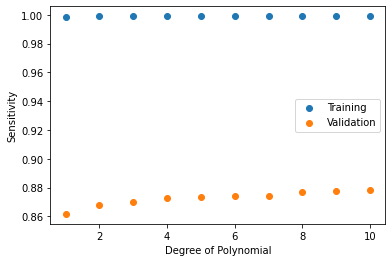

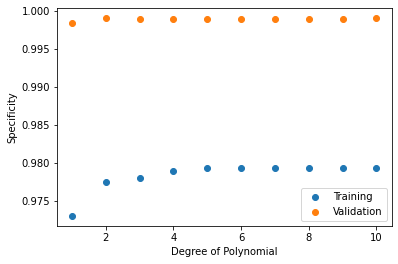

In [43]:
from sklearn import svm
import sklearn.model_selection
import sklearn.svm
import matplotlib.pyplot as plt

def cross_validation_f(data_train, target_train, parameters, folds):
    kf = sklearn.model_selection.KFold(n_splits=folds)

    average_training_sens = np.zeros(len(parameters))
    average_validation_sens = np.zeros(len(parameters))
    average_training_spec = np.zeros(len(parameters))
    average_validation_spec = np.zeros(len(parameters))
    
    for i in range(len(parameters)):
        parameter = parameters[i]
        
        training_sensitivity, training_specificity = [], []
        validation_sentivity, validation_specificity = [], []

        for train_index, test_index in kf.split(data_train):
            #print(train_index.shape)
            data_fold_train = data_train[train_index,:]
            data_fold_test = [target_train[i] for i in train_index] #target_train[train_index]
            validation_train, validation_test = data_train[test_index, :], [target_train[i] for i in test_index]#target_train[test_index]

            clf = svm.SVC(C=parameter, kernel ='poly')
            train = clf.fit(data_fold_train, data_fold_test)
            predicted_train = train.predict(data_fold_train)
            predicted_validation = train.predict(validation_train)
            
            #print("Parameter: ", parameter, " Train Data Metrics:")
            nb_metric = metric_calc(data_fold_test, predicted_train)
            training_sens = nb_metric.sens()
            training_spec = nb_metric.spec()

            #print("Parameter: ", parameter, " Train Data Metrics:")
            nb_metric = metric_calc(validation_test, predicted_validation)
            validation_sens = nb_metric.sens()
            validation_spec = nb_metric.spec()

            training_sensitivity.append(training_sens)
            validation_sentivity.append(validation_sens)
            training_specificity.append(training_spec)
            validation_specificity.append(validation_spec)
        
        average_training_sens[i] = np.mean(np.array(training_sensitivity))
        average_validation_sens[i] = np.mean(np.array(validation_sentivity))   
        average_training_spec[i] = np.mean(np.array(training_specificity))
        average_validation_spec[i] = np.mean(np.array(validation_specificity))           
    return average_training_sens, average_validation_spec, average_training_spec, average_training_sens

poly_parameters = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
training_sens, validation_sens, training_spec, validation_spec = cross_validation_f(x_train_tfidf, y_train, poly_parameters, 10)
x = np.array(poly_parameters)

plt.scatter(x, training_sens)
plt.scatter(x, validation_sens)

plt.legend(["Training" , "Validation"])
plt.xlabel('Degree of Polynomial') 
plt.ylabel('Sensitivity')
plt.show()

plt.scatter(x, training_spec)
plt.scatter(x, validation_spec)

plt.legend(["Training" , "Validation"])
plt.xlabel('Degree of Polynomial') 
plt.ylabel('Specificity')
plt.show()

In [54]:
#Regular Fitting
SVM_linear = svm.SVC(C=1.0,kernel ='linear')
SVM_linear.fit(x_train_tfidf, y_train)

SVM_poly = svm.SVC(C=1.0,kernel ='poly', degree=10)
SVM_poly.fit(x_train_tfidf, y_train)

SVM_rbf = svm.SVC(C=1.0,kernel ='rbf')
SVM_rbf.fit(x_train_tfidf, y_train)

SVM_sigmoid = svm.SVC(C=1.0,kernel ='sigmoid')
SVM_sigmoid.fit(x_train_tfidf, y_train)

#Data Augmentation Fitting
SVM_linear_1 = svm.SVC(C=1.0,kernel ='linear')
SVM_linear_1.fit(x_train_tfidf_1, y_train_1)

SVM_linear_2 = svm.SVC(C=1.0,kernel ='linear')
SVM_linear_2.fit(x_train_tfidf_2, y_train_2)

SVM_linear_del = svm.SVC(C=1.0,kernel ='linear')
SVM_linear_del.fit(x_train_tfidf_del, y_train)

SVC(kernel='linear')

In [55]:
test_tokens = token_generator(test_text)
svm_linear_predictions = list()
svm_poly_predictions = list()
svm_rbf_predictions = list()
svm_sigmoid_predictions = list()

svm_linear_predictions_1 = list()
svm_linear_predictions_2 = list()
svm_linear_predictions_del = list()

for token in test_tokens:
  test_sparse_vector = sparse_vector_create(train_vocab_dict.doc2bow(token),len(train_vocab_dict))
  x_test_tfidf = tfidf.transform(test_sparse_vector.reshape(1,-1))
  svm_linear_predictions.append(SVM_linear.predict(x_test_tfidf)[0])
  svm_poly_predictions.append(SVM_poly.predict(x_test_tfidf)[0])
  svm_rbf_predictions.append(SVM_rbf.predict(x_test_tfidf)[0])
  svm_sigmoid_predictions.append(SVM_sigmoid.predict(x_test_tfidf)[0])

  x_test_tfidf_del = tfidf_del.transform(test_sparse_vector_del.reshape(1,-1))
  svm_linear_predictions_1.append(SVM_linear_1.predict(x_test_tfidf)[0])
  svm_linear_predictions_2.append(SVM_linear_2.predict(x_test_tfidf)[0])
  svm_linear_predictions_del.append(SVM_linear_del.predict(x_test_tfidf_del)[0])
  

# Where to next?
So far we have only examined sparse word vectors. That is, vector representations of words that contain many 0's and sparsely contain data. This may perform adequately for the models presented, but for many cases, working with large-dimension vectors can be a large problem due to high memory usage and computational cost.

There has been work done to create dense vectors of words based on "distributed" representations (aka based on word distribution). These vectors are are usually only several tens to hundreds of dimensions long as opposed to many thousands. Earlier approaches for doing so include Word2vec and GloVe which create static vectors for word representations. Newer embedding approaches integrate context into embedding creation such as seen in ELMo or BERT's embedding process. 

Popular deep learning architectures for analyzing text include convolutional neural networks, recurrent neural networks and its cousins LSTM and GRU as well as the more recent transformer model. Deep learning approaches to NLP start with converting words into a vector in an embedding layer, often using one of the aforementioned techniques. We will not explore deep learning approaches to NLP in this tutorial, but since we have mentioned a number of popular NLP packages, we will also mention [HuggingFace](https://huggingface.co/) for their extensive NLP deep learning library. 

# Evaluation

Evaluation of model performance is a very important part of the NLP pipeline. Common metrics (for classification) include sensitivity (recall), specificity, positive predictive value (precision), and the F1 score. These quantities can be derived from a "confusion matrix" which is simply a matrix that tabulates model classification results into the categories of true negatives, false positives, false negatives, and true positives.

For sklearn confusion matrix, the format is - row i is actual class, row j is predicted class. For our case, 0 - normal, 1 - abnormal. thus $C_{0,0}$ is true negatives, $C_{0,1}$ is false positive, $C_{1,0}$ is false negative, $C_{1,1}$ is true positives where $C_{i,j}$ refers to element in row i and column j. In this example, a "positive" label by the model is the equivalent of flagging an example as "abnormal".

Note we cannot naturally generate a ROC curve for Naive Bayes or SVM as ROC curves require some threshold (usually some "probability" cut off for prediction of one class or another) but Naive Bayes simply compares two(or more) quantities with each other to determine class. While using relative comparisons works reasonably well, the numerical value of these outputs is unstable and unsuitable for a fixed cutoff.

In [56]:
from sklearn import metrics

class metric_calc:
  def __init__(self, y,y_hat):
  # y is true label, y_hat is predicted label
    self.y_hat = y_hat
    self.y = y
    conf_matrix = metrics.confusion_matrix(y,y_hat)
    
    self.true_neg = conf_matrix[0][0]
    self.false_pos = conf_matrix[0][1]
    self.false_neg = conf_matrix[1][0]
    self.true_pos = conf_matrix[1][1]

  def conf_matrix_values(self):
    print(f"TN: {self.true_neg}, FP: {self.false_pos}, FN: {self.false_neg} TP: {self.true_pos}")

  def sens_spec(self):
    sens = self.true_pos/(self.true_pos+self.false_neg)
    spec = self.true_neg/(self.true_neg+self.false_pos)
    print(f"Sensitivity (aka recall) is {sens:.4f}")
    print(f"Specificity is {spec:.4f}")

  def sens(self):
    sens = self.true_pos/(self.true_pos+self.false_neg)
    return sens

  def spec(self):
    spec = self.true_neg/(self.true_neg+self.false_pos)
    return spec

  def incorrect_index(self):
    # return indices of examples that are incorrectly predicted
    index = list()
    for i,label in enumerate(self.y):
      if label != self.y_hat[i]:
        index.append(i)
    return index

In [57]:
#Regular Evaluation
print("Naive Bayes")
nb_metric = metric_calc(y_test,nb_predictions)
nb_metric.conf_matrix_values()
nb_metric.sens_spec()

print("SVM-Linear")
svm_linear_metric = metric_calc(y_test,svm_linear_predictions)
svm_linear_metric.conf_matrix_values()
svm_linear_metric.sens_spec()

print("SVM-Poly")
svm_poly_metric = metric_calc(y_test,svm_poly_predictions)
svm_poly_metric.conf_matrix_values()
svm_poly_metric.sens_spec()

print("SVM-rbf")
svm_rbf_metric = metric_calc(y_test,svm_rbf_predictions)
svm_rbf_metric.conf_matrix_values()
svm_rbf_metric.sens_spec()

print("SVM-sigmoid")
svm_sigmoid_metric = metric_calc(y_test,svm_sigmoid_predictions)
svm_sigmoid_metric.conf_matrix_values()
svm_sigmoid_metric.sens_spec()

#Data Augmentation Evaluation
svm_linear_metric_1 = metric_calc(y_test,svm_linear_predictions_1)
svm_linear_metric_1.conf_matrix_values()
svm_linear_metric_1.sens_spec()

svm_linear_metric_2 = metric_calc(y_test,svm_linear_predictions_2)
svm_linear_metric_2.conf_matrix_values()
svm_linear_metric_2.sens_spec()

svm_linear_metric_del = metric_calc(y_test,svm_linear_predictions_del)
svm_linear_metric_del.conf_matrix_values()
svm_linear_metric_del.sens_spec()

Naive Bayes
TN: 211, FP: 12, FN: 46 TP: 325
Sensitivity (aka recall) is 0.8760
Specificity is 0.9462
SVM-Linear
TN: 209, FP: 14, FN: 12 TP: 359
Sensitivity (aka recall) is 0.9677
Specificity is 0.9372
SVM-Poly
TN: 164, FP: 59, FN: 1 TP: 370
Sensitivity (aka recall) is 0.9973
Specificity is 0.7354
SVM-rbf
TN: 206, FP: 17, FN: 11 TP: 360
Sensitivity (aka recall) is 0.9704
Specificity is 0.9238
SVM-sigmoid
TN: 209, FP: 14, FN: 14 TP: 357
Sensitivity (aka recall) is 0.9623
Specificity is 0.9372
TN: 216, FP: 7, FN: 21 TP: 350
Sensitivity (aka recall) is 0.9434
Specificity is 0.9686
TN: 215, FP: 8, FN: 16 TP: 355
Sensitivity (aka recall) is 0.9569
Specificity is 0.9641
TN: 0, FP: 223, FN: 0 TP: 371
Sensitivity (aka recall) is 1.0000
Specificity is 0.0000


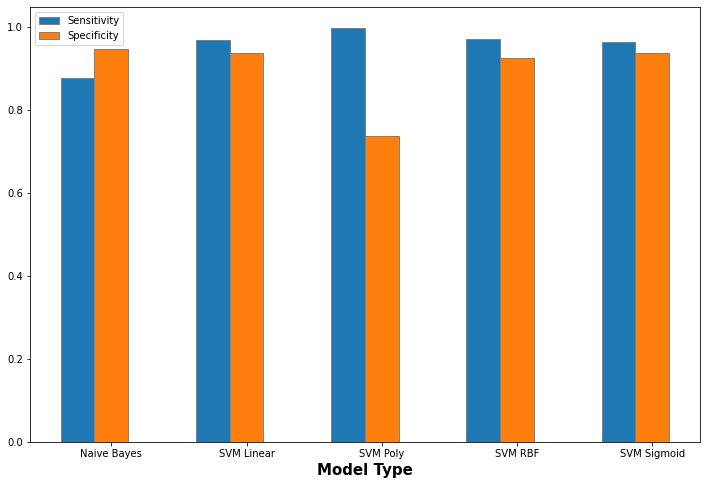

In [58]:
import numpy as np
import matplotlib.pyplot as plt
 
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
sensitivity = [nb_metric.sens(), svm_linear_metric.sens(), svm_poly_metric.sens(), svm_rbf_metric.sens(), svm_sigmoid_metric.sens()]
specificity = [nb_metric.spec(), svm_linear_metric.spec(), svm_poly_metric.spec(), svm_rbf_metric.spec(), svm_sigmoid_metric.spec()]
 
# Set position of bar on X axis
br_sensitivity = np.arange(len(sensitivity))
br_specificity = [x + barWidth for x in br_sensitivity]
 
# Make the plot
plt.bar(br_sensitivity, sensitivity, width = barWidth,
        edgecolor ='grey', label ='Sensitivity')
plt.bar(br_specificity, specificity, width = barWidth,
        edgecolor ='grey', label ='Specificity')
 
# Adding Xticks
plt.xlabel('Model Type', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(specificity))],
        ['Naive Bayes', 'SVM Linear', 'SVM Poly', 'SVM RBF', 'SVM Sigmoid'])
 
plt.legend()
plt.show()

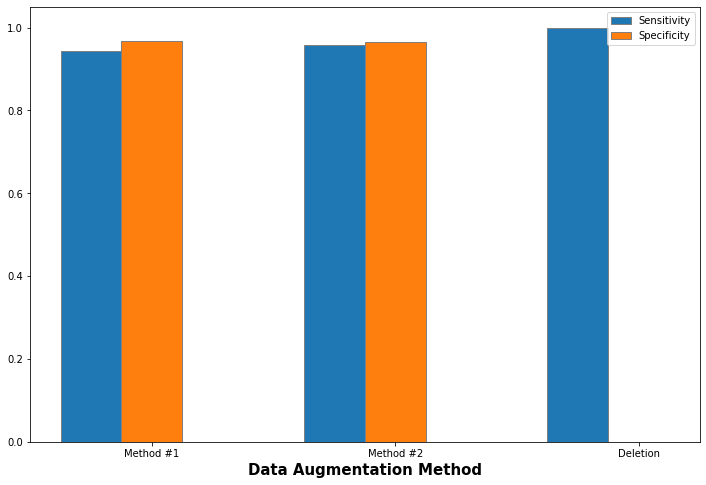

In [60]:
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
sensitivity = [svm_linear_metric_1.sens(), svm_linear_metric_2.sens(), svm_linear_metric_del.sens()]
specificity = [svm_linear_metric_1.spec(), svm_linear_metric_2.spec(), svm_linear_metric_del.spec()]
 
# Set position of bar on X axis
br_sensitivity = np.arange(len(sensitivity))
br_specificity = [x + barWidth for x in br_sensitivity]
 
# Make the plot
plt.bar(br_sensitivity, sensitivity, width = barWidth,
        edgecolor ='grey', label ='Sensitivity')
plt.bar(br_specificity, specificity, width = barWidth,
        edgecolor ='grey', label ='Specificity')
 
# Adding Xticks
plt.xlabel('Data Augmentation Method', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(specificity))],
        ['Method #1', 'Method #2', 'Deletion'])
 
plt.legend()
plt.show()

# Manual examination of model

Sometimes it is helpful (or simply entertaining) to try inserting your own free text into a NLP model and seeing how it behaves

In [61]:
#@title Try entering some free text for classification via the classifiers we trained
user_text = "everything looks fine" #@param {type:"string"}
user_token = preprocess(nlp,user_text)
user_sparse_vector = sparse_vector_create(train_vocab_dict.doc2bow(user_token),len(train_vocab_dict))
user_nb_prediction = nb_classifier.predict(user_sparse_vector.reshape(1,-1))[0]
user_svm_prediction = SVM_linear.predict(user_sparse_vector.reshape(1,-1))[0]

print("Convention used - 0 is normal, 1 is abnormal")
print(f"Naive Bayes: {user_nb_prediction}")
print(f"SVM: {user_svm_prediction}")

Convention used - 0 is normal, 1 is abnormal
Naive Bayes: 1
SVM: 1


## Error Analysis

Manual examination of model errors for systematic errors is also an important post evaluation step.

In [62]:
troubleshoot_df = test_df.iloc[svm_linear_metric.incorrect_index()][["full-text","label"]]
troubleshoot_df["SVM"] = [svm_linear_predictions[i] for i in svm_linear_metric.incorrect_index()]
troubleshoot_df

,full-text,label,SVM
1140,The lungs are clear. No pleural effusion is seen. The heart and mediastinum are normal. Arthritic changes of the spine are present. No active disease.,normal,1
2869,"Lungs are clear. No focal consolidation, effusion, or pneumothorax. Interval resolution of left effusion. Central venous dialysis catheter unchanged in position. Heart and mediastinal contours are normal. Osseous structures intact. No acute cardiopulmonary disease.",abnormal,0
2164,Lungs are clear bilaterally. Cardiac and mediastinal silhouettes are normal. Pulmonary vasculature is normal. No pneumothorax or pleural effusion. Limbus vertebra noted within the partial visualized lumbar vertebral body. No acute cardiopulmonary disease.,normal,1
2836,No there is an dextroscoliosis of the thoracic spine. The cardiomediastinal silhouette and pulmonary vasculature are within normal limits. There is no pneumothorax or pleural effusion. There are no focal areas of consolidation. No acute cardiopulmonary abnormality.,abnormal,0
2854,"The heart is normal in size and contour. The lungs are clear, without evidence of infiltrate. There is no pneumothorax or effusion. Multiple punctate round XXXX XXXX over the abdomen on the lateral view. These may reside within, or outside of the patient. No acute cardiopulmonary disease.",normal,1
3307,"No focal lung opacity, pleural effusion or pneumothorax. Cardiomediastinal silhouette is unremarkable. No focal lung opacity, pleural effusion of pneumothorax.",normal,1
3125,"PA and lateral views of the chest were obtained. The cardiomediastinal silhouette is within limits. Postoperative changes from spinal rods are demonstrated. There is elevation of the left hemidiaphragm. Multiple colonic loops are demonstrated in the left upper quadrant. The lungs are clear bilaterally. Left humeral head is positioned anterior and inferior to the glenoid, concerning for anterior shoulder subluxation. 1. No active cardiopulmonary disease. 2. Left humeral head is positioned anterior and inferior to the glenoid, concerning for anterior shoulder subluxation. This is XXXX related to the muscular dystrophy and decreased shoulder muscles support. 3. XXXX postoperative changes from the spinal XXXX placement.",normal,1
3203,There may be a subtle airspace opacity in the right base near the midclavicular line. There is no pleural effusion or pneumothorax. The heart and mediastinum are normal. The skeletal structures are normal. Possible area of pneumonitis right lower lobe.,normal,1
3298,"Frontal and lateral views of the chest show an unchanged cardiomediastinal silhouette. Normal mediastinal contour, pulmonary XXXX and vasculature, central airways and aeration of the lungs. No focal airspace consolidation or pleural effusion. There is subphrenic intraperitoneal extraluminal XXXX free XXXX. 1. No acute or active cardiac, pulmonary or pleural disease. 2. Pneumoperitoneum, attributed to the patient's recent abdominal surgery.",abnormal,0
1112,"Heart size within normal limits, stable mediastinal and hilar contours. No focal alveolar consolidation, no definite pleural effusion seen. No typical findings of pulmonary edema. XXXX convexity also present on the previous exam. No acute findings",normal,1


In [52]:
troubleshoot_df = test_df.iloc[nb_metric.incorrect_index()][["full-text","label"]]
troubleshoot_df["nb"] = [nb_predictions[i] for i in nb_metric.incorrect_index()]
troubleshoot_df

,full-text,label,nb
1140,The lungs are clear. No pleural effusion is seen. The heart and mediastinum are normal. Arthritic changes of the spine are present. No active disease.,normal,1
944,The heart is normal in size. The mediastinum is unremarkable. The lungs are hypoinflated but clear. No acute disease.,abnormal,0
2469,"The heart is normal in size with normal appearance of the cardiomediastinal silhouette. The lungs are clear without focal airspace opacity, pleural effusion, or pneumothorax. The osseous structures are intact, with mild degenerative changes in the thoracic spine. No acute cardiopulmonary finding.",abnormal,0
2836,No there is an dextroscoliosis of the thoracic spine. The cardiomediastinal silhouette and pulmonary vasculature are within normal limits. There is no pneumothorax or pleural effusion. There are no focal areas of consolidation. No acute cardiopulmonary abnormality.,abnormal,0
2854,"The heart is normal in size and contour. The lungs are clear, without evidence of infiltrate. There is no pneumothorax or effusion. Multiple punctate round XXXX XXXX over the abdomen on the lateral view. These may reside within, or outside of the patient. No acute cardiopulmonary disease.",normal,1
3307,"No focal lung opacity, pleural effusion or pneumothorax. Cardiomediastinal silhouette is unremarkable. No focal lung opacity, pleural effusion of pneumothorax.",normal,1
78,The lungs are clear. Heart size is normal. No pneumothorax. There are endplate changes in the spine. Clear lungs. No acute cardiopulmonary abnormality. .,abnormal,0
1594,"Lungs are hyperexpanded bilaterally, with no focal consolidation, pleural effusion, or pneumothoraces. Cardiomediastinal silhouette is within normal limits. XXXX are unremarkable. No acute cardiopulmonary abnormality.",abnormal,0
3125,"PA and lateral views of the chest were obtained. The cardiomediastinal silhouette is within limits. Postoperative changes from spinal rods are demonstrated. There is elevation of the left hemidiaphragm. Multiple colonic loops are demonstrated in the left upper quadrant. The lungs are clear bilaterally. Left humeral head is positioned anterior and inferior to the glenoid, concerning for anterior shoulder subluxation. 1. No active cardiopulmonary disease. 2. Left humeral head is positioned anterior and inferior to the glenoid, concerning for anterior shoulder subluxation. This is XXXX related to the muscular dystrophy and decreased shoulder muscles support. 3. XXXX postoperative changes from the spinal XXXX placement.",normal,1
664,The heart size is normal. The mediastinal contour is within normal limits. The lungs are free of any focal infiltrates. There are no nodules or masses. No visible pneumothorax. No visible pleural fluid. The XXXX are grossly normal. There is no visible free intraperitoneal air under the diaphragm. Surgical clips are seen the right upper quadrant. 1. No acute radiographic cardiopulmonary process.,abnormal,0


# References

[1] Demner-Fuhshman D, Kohli MD, Rosenman MB, Shooshan SE, Rodriguez L, Antani S, Thoma GR, McDonald CJ. "Preparing a collection of radiology examinations for distribution and retrieval". J. Am. Med. Inform. Assoc. 2016. 23(2). 304-310. https://doi.org/10.1093/jamia/ocv080

[2] Wiggins WF, Kitamura F, Santos I, Prevedello L. "Natural Language Processing of Radiology Text Reports: Interactive Text Classification". Radiol. Artif. Intell. 2021. 3(4). https://doi.org/10.1148/ryai.2021210035

#Further Reading
Jurafsky D, Martin JH. "Speech and Language Processing. An Introduction to Natural Language Processing, Computational Linguistics, and Speech Recognition". Draft. 3ed. September 21, 2021.

Pons E, Braun LM M, Hunink MG Myriam, Kors JA. "Natural Language Processing in Radiology: A Systematic Review". Radiology. 2016. 279(2). 329-343.

Sorin V, Barash Y, Konen E, Klang E. "Deep Learning for Natural Language Processing in Radiology - Fundamentals and a Systematic Review". J. Am. Coll. Radiol. 2020. 17(5). 639-648.

Mozayan A, Fabbri AR, Maneevese M, Tocino I, Chheang Sophie. "Practical Guide to Natural Language Processing for Radiology". Radiographics. 2021. 41(5). 1446-1453.